
Overview of pipeline 
- Download and parse the training data OR load the .npy file
- Transcribe all MIDI songs and store in a 2D matrix
- Train a network to classify each query into one of the songs in database


In [1]:
####################################################################
# Steps for the final design of QbH (TVD+Semi-global)
# 1. Transcribe all MIDI songs, and generate a 2D matrix
# 2. Select the set of queries
# 3. Run a loop: each iteration, send a query and get its rank
# 4. At the end of the loop, compute MRR

In [2]:
import sys
import os
#import seaborn as sds
#import pretty_midi
#import librosa.display
import numpy as np, scipy, scipy.spatial, matplotlib.pyplot as plt
#from align import aligner
#from align.matrix import DNAFULL
#from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from numpy import diff
from six.moves import xrange
#from skimage.restoration import denoise_wavelet, denoise_tv_chambolle
from scipy.signal import find_peaks

#sds.set()
plt.rcParams['figure.figsize'] = (20, 15)
#%matplotlib inline

In [3]:
curr_path = os.getcwd()

### Download the training data and parse in required format

In [ ]:
import urllib
dataset_zip_path = curr_path + '\data\RogerJang_QBSH.zip'
dataset_path = curr_path + '/data/MIR-QBHS/'
urllib.request.urlretrieve('http://mirlab.org/dataset/public/MIR-QBSH.zip', dataset_zip_path )


In [ ]:
import zipfile
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(curr_path + '//data/')

In [4]:
dataset_path = curr_path + '\\data\\MIR-QBSH\\'

In [ ]:
# Load the path to queries, "querypath"

querypath =  dataset_path + 'waveFile\\'
db_x = np.zeros((4500, 250)) # no. of queries to extract
db_y = np.zeros(4500) # label corresponding to each query
db_counter = 0 # counter to access (read/write) db

for year in os.listdir(querypath) :
    if os.path.isdir(os.path.join(querypath, year)) :
        print(os.path.join(querypath, year))
        for person in os.listdir(os.path.join(querypath, year)) :
            if os.path.isdir(os.path.join(querypath, year, person)) :
                for song in os.listdir(os.path.join(querypath, year, person)) :
                    if (song.endswith('.pv')) :
                        db_y[db_counter] = int((song.split("."))[0])
                        singlesong_path = querypath + year + "/" + person + "/" + song
                        db_x[db_counter] = QbH_denoised(singlesong_path)
                        db_counter += 1
                        


### If .npz file is already available, directly read from file

In [6]:
#Save the 2D matrix and labels to .npz file
#np.savez(curr_path + '\\data\\MIR-QBSH\\denoised_wav', X = db_x, y = db_y)


#Load the matrices from .npz file
data = np.load(curr_path + '\\data\\MIR-QBSH\\denoised_wav.npz')
db_x = data['arr_0']
db_y = data['arr_1']

In [5]:
def QbH_denoised(testpath) :
    """
    Function to denosie a query-recording by TVD and pitch_smoothening
    Input: testpath of .pv format
    Output: denoise pitch vector array
    """
    ##################### Loading audio ###########################################################################################################
    querypitch = np.genfromtxt(testpath, filling_values=0)
    querypitch = np.trim_zeros(querypitch)

    #print("Length of query with time information = " + str(len(querypitch)))

    for i in range(len(querypitch)):
        if querypitch[i] == 0 :
            querypitch[i] = querypitch[i-1]

    #################### TVD ###########################################################################################################
    ecg_skimage = denoise_tv_chambolle(querypitch, weight=5, eps=0.00009, n_iter_max=5000, multichannel=False)
    #plt.plot(ecg_skimage)
    #plt.show()
    
    #################### Pitch smoothening ##########################################################################################################
    dy = np.diff(ecg_skimage)
    #plt.plot(dy)
    #plt.show()
    
    stdev = np.std(dy)
    #print(stdev)

    for i in range(len(dy)):
        diff = dy[i] - np.mean(dy)
        if np.absolute(diff) < stdev:
            dy[i] = 0

    #plt.plot(dy)
    #plt.show()
    
    dyabs = np.absolute(dy)
    peaks, _ = find_peaks(dyabs) # peaks stores the indices of peaks
    #k = 0
    #plt.plot(peaks, dyabs[peaks], 'xb-')
    #plt.show()

    ddy = np.zeros(len(dyabs[peaks]))
    dy_corrected = np.copy(dy)

    for i in range(1, len(peaks)) :
        y = dyabs[peaks[i]] - dyabs[peaks[i-1]]
        x = (peaks[i] - peaks[i-1] ) / 25.0 #/25.0 # divide by 25 for equal x, y scales
        tan = np.arctan(np.abs(ddy))
        if x != 0 :
            ddy[i] = y/x

        tan = np.degrees(np.arctan(np.abs(ddy[i])))
        #print("slope= " + str(ddy[i]))
        #print(" tan= " + str(tan))
        if tan > 80 :
            minimum = min(dyabs[peaks[i]], dyabs[peaks[i-1]])
            minidx = 0
            if dyabs[peaks[i]] == minimum : 
                minidx = peaks[i]
            else :
                minidx = peaks[i-1]
            #print(peaks[i], peaks[i-1], minidx)
            dy_corrected[minidx] = 0
    #print(dy_corrected)
    #plt.plot(dy_corrected)
    #plt.show()
    
    #################### RECONSTRUCTING THE QUERY PITCH VECTOR ###################################################
    #plt.plot(dy_corrected)
    #plt.show()
    peaks1, _ = find_peaks(np.abs(dy_corrected))
    #plt.plot(peaks1, dy_corrected[peaks1], "x")
    #plt.xlim(0, 250)
    #plt.show()

    for i in range(1, len(ecg_skimage)):
        if (i in peaks1) and (i != len(ecg_skimage)-1) :
            ecg_skimage[i] = ecg_skimage[i+1]
        else :
            ecg_skimage[i] = ecg_skimage[i-1]

    #plt.plot(ecg_skimage)
    #plt.show()
    
    querypitch = ecg_skimage
    querypitch = np.pad(querypitch, (0, 250 - len(querypitch)), 'constant', constant_values=(0, 0)) 
    return querypitch
    


######################## End of QbH for this query ######################################################################################################################


In [ ]:
print(db_y[400])
plt.plot(db_x[400])
plt.show()

In [ ]:
print(db_x.shape)
print(db_y.shape)
print(max(db_y))
print(min(db_y))

### Train a network with simple FC layers

In [19]:
# Imports
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from trainer import fit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.manifold import TSNE
import seaborn as sns


%matplotlib inline
cuda = torch.cuda.is_available()


### Auxilliary fxns to plot embeddings

In [12]:
#TODO: needs some verification, dimenstion is probably incorrect
def plot_embeddings(embeddings, targets, num_classes, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(num_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,33], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, num_classes):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 50))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        count = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            #temp = 
            #print(temp.shape)
            #print(len(images))
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
            count = count+1
            #print(count)
    return embeddings, labels

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 49))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    return f, ax, sc


In [9]:
# Configuration options
feature_vector_length = 250
num_classes = 49

# Load the data
X_train, X_test, y_train, y_test = train_test_split(db_x, db_y, train_size=0.85, random_state=42)

X_train = X_train.reshape(X_train.shape[0], feature_vector_length)
X_test = X_test.reshape(X_test.shape[0], feature_vector_length)

# Convert into greyscale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

class RJ_dataset(Dataset):
   def __init__(self, data, labels):
        self.data_len = data.shape[0]
        self.data = data
        self.labels = torch.tensor(labels, dtype=torch.long)
   def __len__(self):
        return self.data_len
   def __getitem__(self, index):
        pitch_vector = self.data[index,:]
        label = self.labels[index]
        return pitch_vector,label

    
train_dataset = RJ_dataset(X_train,y_train)
test_dataset = RJ_dataset(X_test,y_test)

# Set up data loaders
batch_size = 100
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import FCNet
from metrics import AccumulatedAccuracyMetric

fc_net = FCNet(input_size=feature_vector_length, num_classes=num_classes)
model = fc_net
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-1
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 100
log_interval = 10

In [10]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

D:\AnacondaInstall\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/3825 (0%)]	Loss: 5.853703	Accuracy: 3.0
Train: [1000/3825 (26%)]	Loss: 43292.632019	Accuracy: 1.3636363636363635
Train: [2000/3825 (51%)]	Loss: 38598.711914	Accuracy: 1.9523809523809523
Train: [3000/3825 (77%)]	Loss: 36203.381104	Accuracy: 1.7419354838709677
Epoch: 1/100. Train set: Average loss: 42294.3006	Accuracy: 1.7254901960784315
Epoch: 1/100. Validation set: Average loss: 36325.8337	Accuracy: 1.4814814814814814
Train: [0/3825 (0%)]	Loss: 32745.818359	Accuracy: 3.0
Train: [1000/3825 (26%)]	Loss: 92674.921094	Accuracy: 1.7272727272727273
Train: [2000/3825 (51%)]	Loss: 40566.939189	Accuracy: 1.380952380952381
Train: [3000/3825 (77%)]	Loss: 19499.648047	Accuracy: 1.6129032258064515
Epoch: 2/100. Train set: Average loss: 41930.6919	Accuracy: 1.6209150326797386
Epoch: 2/100. Validation set: Average loss: 11848.3255	Accuracy: 2.814814814814815
Train: [0/3825 (0%)]	Loss: 16043.322266	Accuracy: 2.0
Train: [1000/3825 (26%)]	Loss: 45081.022778	Accuracy: 2.272727272727273
Train: [

Epoch: 20/100. Validation set: Average loss: 4.0606	Accuracy: 3.5555555555555554
Train: [0/3825 (0%)]	Loss: 3.972200	Accuracy: 1.0
Train: [1000/3825 (26%)]	Loss: 4.168411	Accuracy: 4.0
Train: [2000/3825 (51%)]	Loss: 4.191861	Accuracy: 4.0476190476190474
Train: [3000/3825 (77%)]	Loss: 4.210963	Accuracy: 3.806451612903226
Epoch: 21/100. Train set: Average loss: 4.1860	Accuracy: 3.503267973856209
Epoch: 21/100. Validation set: Average loss: 4.0560	Accuracy: 3.5555555555555554
Train: [0/3825 (0%)]	Loss: 4.139792	Accuracy: 2.0
Train: [1000/3825 (26%)]	Loss: 4.261336	Accuracy: 2.727272727272727
Train: [2000/3825 (51%)]	Loss: 4.154888	Accuracy: 3.3333333333333335
Train: [3000/3825 (77%)]	Loss: 4.206243	Accuracy: 3.5483870967741935
Epoch: 22/100. Train set: Average loss: 4.1974	Accuracy: 3.581699346405229
Epoch: 22/100. Validation set: Average loss: 4.0515	Accuracy: 3.5555555555555554
Train: [0/3825 (0%)]	Loss: 4.152067	Accuracy: 4.0
Train: [1000/3825 (26%)]	Loss: 4.170128	Accuracy: 3.18181818

Train: [1000/3825 (26%)]	Loss: 4.238452	Accuracy: 3.4545454545454546
Train: [2000/3825 (51%)]	Loss: 4.138755	Accuracy: 3.5238095238095237
Train: [3000/3825 (77%)]	Loss: 4.118179	Accuracy: 3.5483870967741935
Epoch: 41/100. Train set: Average loss: 4.1661	Accuracy: 3.581699346405229
Epoch: 41/100. Validation set: Average loss: 4.0421	Accuracy: 3.4074074074074074
Train: [0/3825 (0%)]	Loss: 4.338438	Accuracy: 3.0
Train: [1000/3825 (26%)]	Loss: 4.187286	Accuracy: 3.090909090909091
Train: [2000/3825 (51%)]	Loss: 4.175318	Accuracy: 3.6666666666666665
Train: [3000/3825 (77%)]	Loss: 4.081898	Accuracy: 3.5161290322580645
Epoch: 42/100. Train set: Average loss: 4.1734	Accuracy: 3.581699346405229
Epoch: 42/100. Validation set: Average loss: 4.0421	Accuracy: 3.4074074074074074
Train: [0/3825 (0%)]	Loss: 4.099566	Accuracy: 3.0
Train: [1000/3825 (26%)]	Loss: 4.254369	Accuracy: 2.8181818181818183
Train: [2000/3825 (51%)]	Loss: 4.190214	Accuracy: 3.2857142857142856
Train: [3000/3825 (77%)]	Loss: 4.1268

Train: [1000/3825 (26%)]	Loss: 4.205323	Accuracy: 3.8181818181818183
Train: [2000/3825 (51%)]	Loss: 4.175067	Accuracy: 3.857142857142857
Train: [3000/3825 (77%)]	Loss: 4.185832	Accuracy: 3.7096774193548385
Epoch: 61/100. Train set: Average loss: 4.1777	Accuracy: 3.581699346405229
Epoch: 61/100. Validation set: Average loss: 4.0421	Accuracy: 3.4074074074074074
Train: [0/3825 (0%)]	Loss: 4.041121	Accuracy: 2.0
Train: [1000/3825 (26%)]	Loss: 4.088042	Accuracy: 3.4545454545454546
Train: [2000/3825 (51%)]	Loss: 4.150326	Accuracy: 3.4761904761904763
Train: [3000/3825 (77%)]	Loss: 4.208424	Accuracy: 3.6129032258064515
Epoch: 62/100. Train set: Average loss: 4.1856	Accuracy: 3.581699346405229
Epoch: 62/100. Validation set: Average loss: 4.0421	Accuracy: 3.4074074074074074
Train: [0/3825 (0%)]	Loss: 4.076599	Accuracy: 3.0
Train: [1000/3825 (26%)]	Loss: 4.180984	Accuracy: 3.727272727272727
Train: [2000/3825 (51%)]	Loss: 4.156976	Accuracy: 3.5238095238095237
Train: [3000/3825 (77%)]	Loss: 4.14946

Train: [1000/3825 (26%)]	Loss: 4.146700	Accuracy: 3.4545454545454546
Train: [2000/3825 (51%)]	Loss: 4.132670	Accuracy: 3.6666666666666665
Train: [3000/3825 (77%)]	Loss: 4.260112	Accuracy: 3.3870967741935485
Epoch: 81/100. Train set: Average loss: 4.1787	Accuracy: 3.581699346405229
Epoch: 81/100. Validation set: Average loss: 4.0421	Accuracy: 3.4074074074074074
Train: [0/3825 (0%)]	Loss: 4.056130	Accuracy: 4.0
Train: [1000/3825 (26%)]	Loss: 4.239976	Accuracy: 4.181818181818182
Train: [2000/3825 (51%)]	Loss: 4.226302	Accuracy: 3.6666666666666665
Train: [3000/3825 (77%)]	Loss: 4.150486	Accuracy: 3.5806451612903225
Epoch: 82/100. Train set: Average loss: 4.1701	Accuracy: 3.581699346405229
Epoch: 82/100. Validation set: Average loss: 4.0421	Accuracy: 3.4074074074074074
Train: [0/3825 (0%)]	Loss: 4.347189	Accuracy: 2.0
Train: [1000/3825 (26%)]	Loss: 4.272249	Accuracy: 3.4545454545454546
Train: [2000/3825 (51%)]	Loss: 4.164366	Accuracy: 3.5238095238095237
Train: [3000/3825 (77%)]	Loss: 4.0754

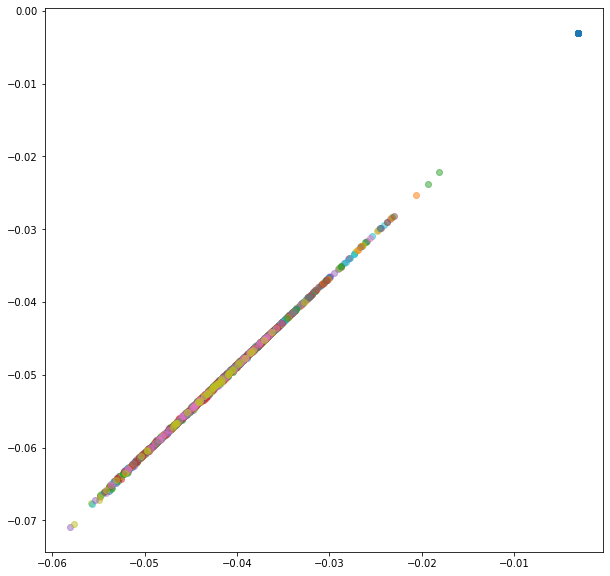

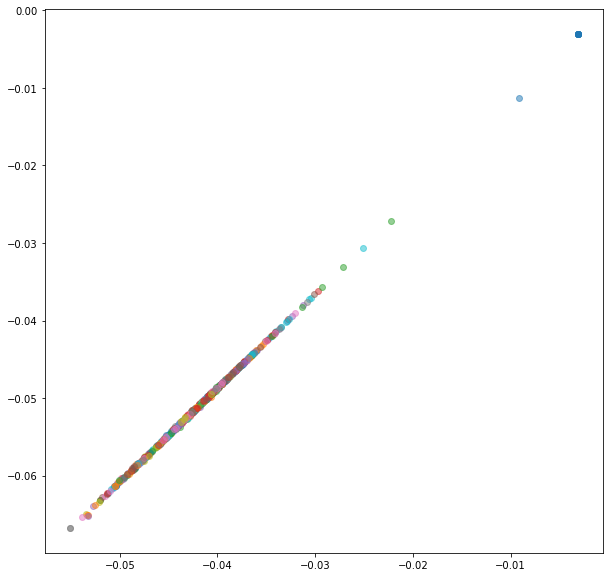

In [13]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model, num_classes)
plot_embeddings(train_embeddings_baseline, train_labels_baseline, num_classes)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model, num_classes)
plot_embeddings(val_embeddings_baseline, val_labels_baseline, num_classes)

IndexError: index 19 is out of bounds for axis 0 with size 10

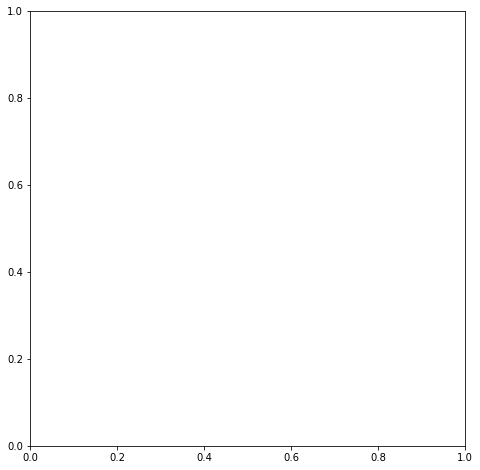

In [20]:
z_reduced = TSNE(random_state=42).fit_transform(train_embeddings_baseline)
scatter(z_reduced, train_labels_baseline)

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.collections.PathCollection at 0x11ea2cb09d0>)

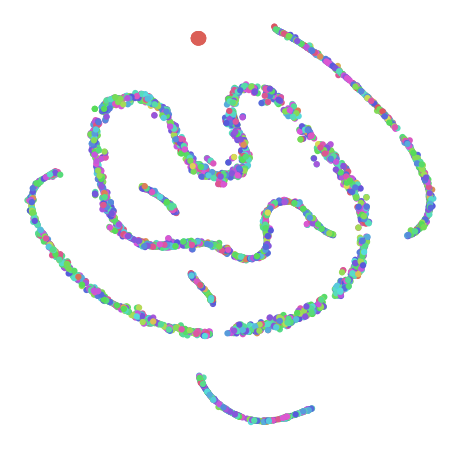

In [24]:
train_labels_baseline.shape


(3825,)

In [ ]:
train_dataset[4]

In [ ]:
Archived
# Run a LOOP to transcribe all the MIDI files in the dataset and store in a 2D ARRAY

# List all files in a directory using os.listdir
basepath = 'audio/train/'
N = 48

# create a 2D array with np empty()
pitchvalue = np.zeros((48, 250000)) # assuming that length of a song does not exceed 500s ~ 8min

#n = len(querypitch)
print('MIDI transcription begins: extracting note sequence of 48 MIDI songs')
for data in os.listdir(basepath):
    if data.endswith('.mid'):
        # data is a string, eg, "00001.mid". we want 00001 so we split.
        entry = data.split(".")
        # counter for row number of the 2D array
        # Load MIDI file into PrettyMIDI object
        midifile = pretty_midi.PrettyMIDI(basepath + data)
        for i in range(len(midifile.instruments)):
            # Construct a PrettyMIDI object.
            # We'll specify that it will have a tempo of 80bpm.
            #pm = pretty_midi.PrettyMIDI(initial_tempo=80)
            # if(len(midifile.instruments[i].pitch_bends) == 0):
                #print(entry[0] + '.mid'+ ' is being sampled')
                #print(midifile.instruments[i].notes)
                #print(midifile.instruments[i].pitch_bends)
                #print(len(midifile.instruments[i].pitch_bends))

                # sampling rate r of MIDI should be the same as SR of query 
                # length of each query = 8s and n = length of querypitch vector
                #r = 8/n 
                k = 0 # counter for array pitchvalue
                t = 0.007*k # to keep time (discretization of the notes has been done at intervals of 2 ms)
                for j in range(len(midifile.instruments[i].notes)):
                    start = midifile.instruments[i].notes[j].start
                    #print(start)
                    end = midifile.instruments[i].notes[j].end
                    pitch = midifile.instruments[i].notes[j].pitch
                    t = start
                    while t >= start and t <= end:
                        k = int(t/0.007)
                        pitchvalue[int(entry[0])-1][k] = pitch
                        #print(pitch)
                        t += 0.007


print("End of Step: MIDI transcription")
print("...................................................................")